## Lens Tutorial

This tutorial illustrates the construction of optics.Lens objects in the MORTICIA sensor package.

In [1]:
import numpy as np
import pandas as pd
import xarray
xD = xarray.DataArray  # Abbreviation for creating xarray.DataArray objects
import matplotlib.pyplot as plt
import scipy.interpolate
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
def U_(units):
    # Utility function for pint Quantity of 1.0 with given units
    return Q_(1.0, units)
%matplotlib inline
# Set plot default figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import morticia.sensor.optics as optics
import morticia.sensor.electro as electro
from morticia.tools.xd import *
%load_ext autoreload
%aimport morticia.sensor.optics
%aimport morticia.sensor.electro
%autoreload 1

In [2]:
# Set up the spectral transmission function for a optics.Lens object
spec_trans = xarray.DataArray([ 0.0, 0.4, 0.75, 0.93, 0.925, 0.91, 0.89, 0.4, 0.0],                      
                   [('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm'})], 
                   name='trn',
                   attrs={'units': '', 'extrap_val': 0.0})
spec_wfe = xarray.DataArray([0.02, 0.01], [('wvl', [550.0, 1000.0], {'units': 'nm'})], 
                          name='wfe', 
                          attrs={'units': '', 'extrap_val': 0.0})

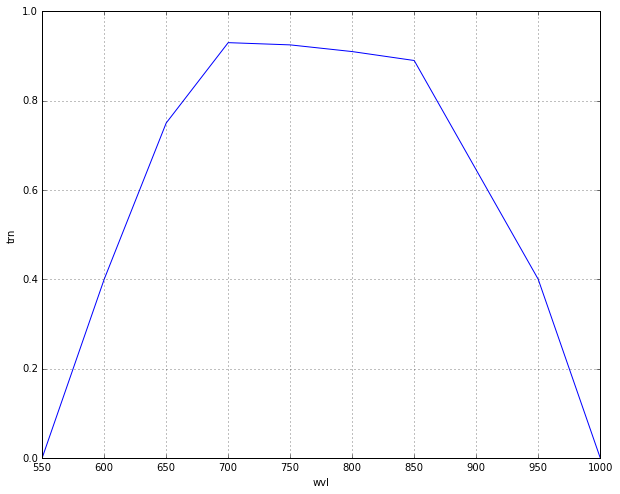

In [3]:
# Plot the spectral transmission function
spec_trans.plot()
plt.grid()

In [4]:
# Create a lens with above transmission and WFE
# Focal length is 30 mm, focal ratio (fno) is 1.0, central obscuration of 50%
mylens = optics.Lens(efl=[30, 'mm'], fno=1.0, trn=spec_trans, wfe=spec_wfe, obs=0.5)

In [5]:
mylens

Effective Focal Length : 30.0 mm
Focal Ratio : 1.0 
Attributes :
['spf_max', 'trn', 'rms_wfe_defocus', 'efl', 'rms_wfe_aberr', 'wvl', 'fno', 'rms_wfe_total', 'cutoff_max', 'mtf', 'obs', 'spf', 'attrs']

In [6]:
mylens.mtf['spf']

<xarray.DataArray 'spf' (spf: 25)>
array([    0.        ,    83.33333333,   166.66666667,   250.        ,
         333.33333333,   416.66666667,   500.        ,   583.33333333,
         666.66666667,   750.        ,   833.33333333,   916.66666667,
        1000.        ,  1083.33333333,  1166.66666667,  1250.        ,
        1333.33333333,  1416.66666667,  1500.        ,  1583.33333333,
        1666.66666667,  1750.        ,  1833.33333333,  1916.66666667,
        2000.        ])
Coordinates:
  * spf      (spf) float64 0.0 83.33 166.7 250.0 333.3 416.7 500.0 583.3 ...
Attributes:
    units: 1/mm
    long_name: Linear Spatial Frequency

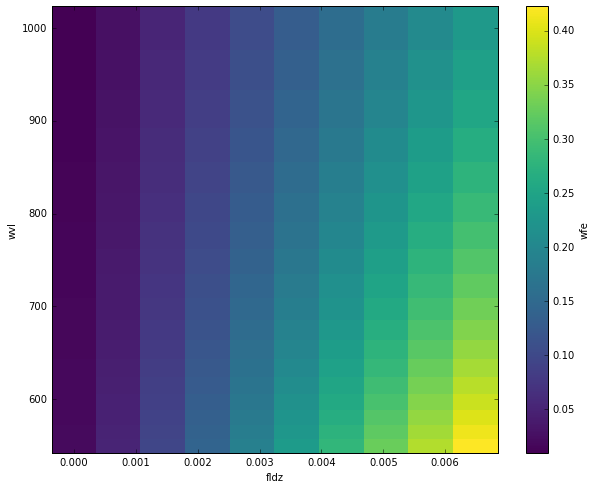

In [7]:
# Plot the total RMS wavefront error as a function of defocus (fldz) and wavelength (wvl)
# BTW, this would not work if the wfe were also a function of other variables (fldx, fldy)
# NOte that at zero defocus (fldz = 0)the WFE is a minimum for the shortest wavelength
mylens.rms_wfe_total.plot()

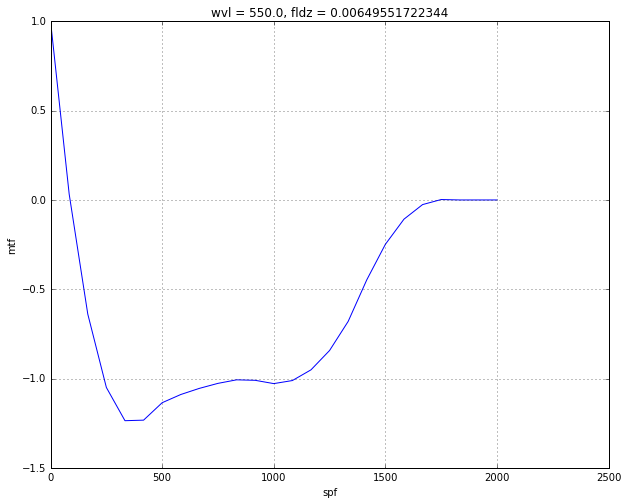

In [8]:
# Plot the MTF of the lens at extreme defocus
mylens.mtf[:,0,-1].plot()
plt.grid()

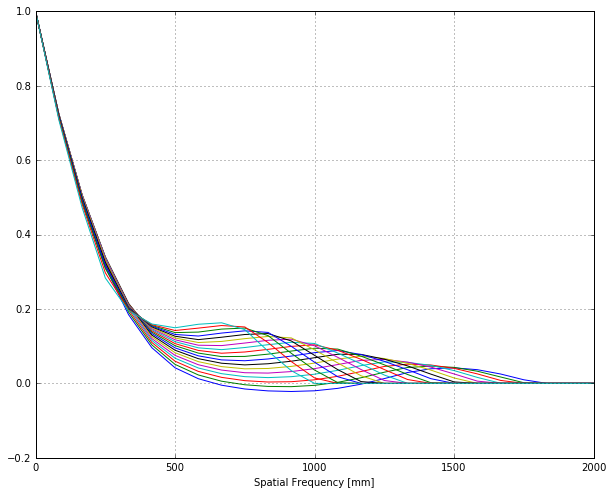

In [9]:
# Plot all the through-frequency MTFs at zero defocus
plt.plot(mylens.mtf['spf'], mylens.mtf[:,:,4])
plt.xlabel('Spatial Frequency [mm]')
plt.ylabel('')
plt.xlim([0, 2000])
plt.grid()

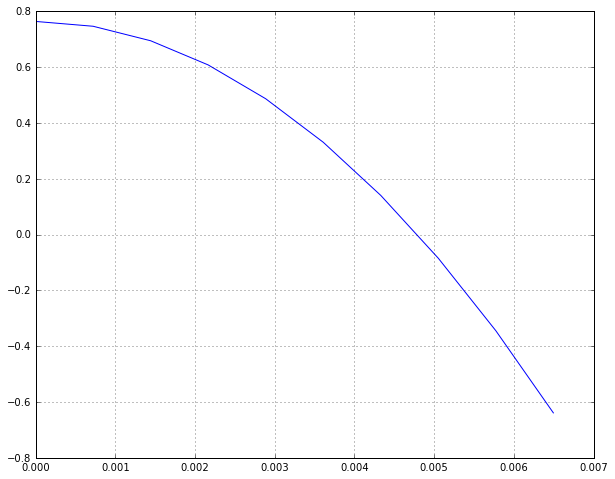

In [10]:
plt.plot(mylens.mtf['fldz'], mylens.mtf[2,0,:])
plt.grid()

In [11]:
# Create a CCD Focal Plane Array model for the Kodak KAI11002 sensor
# First read the spectral quantum efficiency data
KodakKA11002_SQE = np.genfromtxt('./data/fpa/KodakKAI11002_SQE.csv', delimiter=',', skip_header=1)
# Convert to a DataArray
KodakKA11002_SQE = xarray.DataArray(KodakKA11002_SQE[:,1], [('wvl', KodakKA11002_SQE[:,0], {'units': 'um'})], 
                                  name='sqe', attrs={'units':''})

In [12]:
# Instantiate the FocalPlaneArray object
CCD = electro.FocalPlaneArray(pitch=[12.0, 6.0, 'um'], aperture=[9.0, 'um'], pixels=[4008, 2672], wellcapacity=[60000.0, 'e'], 
                              readnoise=[32.0, 'e'], darkcurrent=[3846.0, 'e/s'], dsnu=[3.0, '%'], prnu=[2.0, '%'],
                              sqe=KodakKA11002_SQE, darkcurrent_delta_t=[7.0, 'delta_degC'], t_ref=[40.0, 'degC'],
                              temperature=[25.0, 'degC'])
# Print the dark current value at operating temperature of 25.0 deg C
print CCD.darkcurrent, ' at CCD ', CCD.temperature

Pixel Dark Current : 870.85330319 e/s  at CCD  Temperature : 25.0 degC


In [13]:

a,b =  xd_harmonise_interp((CCD.mtf, mylens.mtf))
c = a*b
c

<xarray.DataArray 'mtf' (spf: 110, fldo: 2, wvl: 18, fldz: 10)>
array([[[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.       

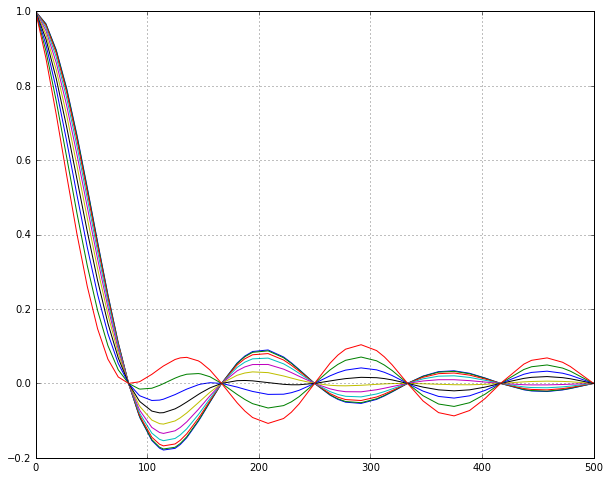

In [14]:
plt.plot(c['spf'], c[:,0,0,:])
plt.ylim([-0.2,1])
plt.xlim([0.0, 500])
plt.grid()

In [ ]:
mylens.mtf['spf']

In [ ]:
mylens.mtf['fldz']

In [ ]:
x = Q_(200, 'count')

In [ ]:
x.to('bit')

In [ ]:
mylens